In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
import os

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = "Fall 23/COMP562"
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
DATA_FOLDER_PATH = os.path.join(GOOGLE_DRIVE_PATH, 'caltech-101_top12')
print(os.listdir(GOOGLE_DRIVE_PATH))
print(os.listdir(DATA_FOLDER_PATH))

['COMP562-Project.ipynb', 'caltech-101_top12', 'val_data_np.npy', 'test_data_np.npy', 'train_data_np.npy', 'Neural Network Paper Section.gdoc', 'train_labels_np.npy', 'val_labels_np.npy', 'test_labels_np.npy', 'neural-net.ipynb', 'Paper.gdoc', 'Logistic Regression paper.gdoc', 'Logistic Regression']
['Faces_easy', 'Leopards', 'brain', 'ketch', 'grand_piano', 'airplanes', 'chandelier', 'car_side', 'bonsai', 'hawksbill', 'Motorbikes', 'watch']


In [ ]:
# Load dataset
dataset = torchvision.datasets.ImageFolder(root=DATA_FOLDER_PATH)

In [ ]:
# Count of each class

from collections import Counter

def get_label_count(label_idxs):
    label_idxs_count = Counter(label_idxs)
    label_idxs_count = sorted(list(label_idxs_count.items()),key=lambda x:x[1] ,reverse=True)
    return label_idxs_count

label_count = get_label_count(dataset.targets)
label_count_topk = [(dataset.classes[x[0]], x[1]) for x in label_count][:20]
print(label_count_topk)
label_count_topk_total_count = sum([x[1] for x in label_count_topk])
print('Total:', label_count_topk_total_count)

[('airplanes', 800), ('Motorbikes', 798), ('Faces_easy', 435), ('watch', 239), ('Leopards', 200), ('bonsai', 128), ('car_side', 123), ('ketch', 114), ('chandelier', 107), ('hawksbill', 100), ('grand_piano', 99), ('brain', 98)]
Total: 3241


In [ ]:
# Images are resized to 3*128*128 preserving aspect ratio

from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import Subset

# set seed
torch.manual_seed(123)

IMAGE_SIZE = 128

# Pad the image to a square
class SquarePad:
    def __call__(self, image):
        max_wh = max(image.size)
        p_left, p_top = [(max_wh - s) // 2 for s in image.size]
        p_right, p_bottom = [max_wh - (s+pad) for s, pad in zip(image.size, [p_left, p_top])]
        padding = (p_left, p_top, p_right, p_bottom)
        return torchvision.transforms.functional.pad(image, padding, 0, 'constant')

dataset.transform = transforms.Compose([SquarePad(),
                                        transforms.ToTensor(),
                                        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE), antialias=True)])

labels = dataset.targets
print("Count of all data:", len(labels))

train_idx, val_test_idx = train_test_split(np.arange(len(labels)),
                                           test_size=0.2,
                                           shuffle=True,
                                           random_state=100,
                                           stratify=labels)

val_test_labels = [dataset.targets[x] for x in val_test_idx]

val_idx, test_idx = train_test_split(np.arange(len(val_test_labels)),
                                      test_size=0.5,
                                      shuffle=True,
                                      random_state=102,
                                      stratify=val_test_labels)

val_idx = [val_test_idx[x] for x in val_idx]
test_idx = [val_test_idx[x] for x in test_idx]

train_data_count = len(train_idx)
val_data_count = len(val_idx)
test_data_count = len(test_idx)

print("Count of train data:", train_data_count)
print("Count of val data:", val_data_count)
print("Count of test data:", test_data_count)

# Train, val, test data 8-1-1 stratified split

train_data = Subset(dataset, train_idx)
val_data = Subset(dataset, val_idx)
test_data = Subset(dataset, test_idx)
# assert no intersection
assert(len(set().intersection(train_idx, val_idx, test_idx))==0)

Count of all data: 3241
Count of train data: 2592
Count of val data: 324
Count of test data: 325


In [ ]:
from collections import Counter

train_labels = [dataset.targets[x] for x in train_idx]
val_labels = [dataset.targets[x] for x in val_idx]
test_labels = [dataset.targets[x] for x in test_idx]

print(sorted(Counter(train_labels).items()))
print(sorted(Counter(val_labels).items()))
print(sorted(Counter(test_labels).items()))

print(dataset.class_to_idx)

[(0, 348), (1, 160), (2, 638), (3, 640), (4, 102), (5, 79), (6, 98), (7, 86), (8, 79), (9, 80), (10, 91), (11, 191)]
[(0, 43), (1, 20), (2, 80), (3, 80), (4, 13), (5, 10), (6, 12), (7, 11), (8, 10), (9, 10), (10, 11), (11, 24)]
[(0, 44), (1, 20), (2, 80), (3, 80), (4, 13), (5, 9), (6, 13), (7, 10), (8, 10), (9, 10), (10, 12), (11, 24)]
{'Faces_easy': 0, 'Leopards': 1, 'Motorbikes': 2, 'airplanes': 3, 'bonsai': 4, 'brain': 5, 'car_side': 6, 'chandelier': 7, 'grand_piano': 8, 'hawksbill': 9, 'ketch': 10, 'watch': 11}


In [ ]:
import matplotlib.pyplot as plt

def show_img_grid(images, nrow=5):
  grid_img = torchvision.utils.make_grid(images, nrow=nrow)
  plt.imshow(grid_img.permute(1, 2, 0))

torch.Size([1, 3, 128, 128]) torch.Size([1])
Motorbikes


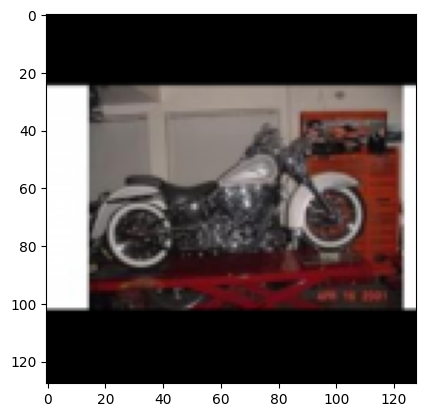

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=1, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)


x, y = next(iter(train_loader))
print(x.shape, y.shape)
show_img_grid(x[0], 1)
image, label = x[0], y[0].item()
print(dataset.classes[label])

Convert train, val, and test images to numpy array

In [ ]:
import skimage

train_data_np = np.zeros(shape=(len(train_loader), 3, 128, 128))

for i, data in enumerate(train_loader):
  image, _ = data   # note image has shape [b, c, h, w]
  image_np = image[0].numpy()
  train_data_np[i] = image_np
  if i%100==0:
    print(i, end=' ')

In [ ]:
val_data_np = np.zeros(shape=(len(val_loader), 3, 128, 128))


for i, data in enumerate(val_loader):
  image, _ = data   # note image has shape [b, c, h, w]
  image_np = image[0].numpy()
  val_data_np[i] = image_np
  if i%100==0:
    print(i, end=' ')

In [ ]:
test_data_np = np.zeros(shape=(len(test_loader), 3, 128, 128))


for i, data in enumerate(test_loader):
  image, _ = data   # note image has shape [b, c, h, w]
  image_np = image[0].numpy()
  test_data_np[i] = image_np
  if i%100==0:
    print(i, end=' ')

In [ ]:
# Save train, val, test ndarrays to disk

np.save(GOOGLE_DRIVE_PATH+'/train_data_np', train_data_np)
np.save(GOOGLE_DRIVE_PATH+'/val_data_np', val_data_np)
np.save(GOOGLE_DRIVE_PATH+'/test_data_np', test_data_np)



In [ ]:
# Run this to load
train_data_np = np.load(GOOGLE_DRIVE_PATH+'/train_data_np.npy')
val_data_np = np.load(GOOGLE_DRIVE_PATH+'/val_data_np.npy')
test_data_np = np.load(GOOGLE_DRIVE_PATH+'/test_data_np.npy')

print(train_data_np.shape)
print(val_data_np.shape)
print(test_data_np.shape)


(2592, 3, 128, 128)
(324, 3, 128, 128)
(325, 3, 128, 128)


In [ ]:
# save labels
# np.save(GOOGLE_DRIVE_PATH+'/train_labels_np', train_labels_np)
# np.save(GOOGLE_DRIVE_PATH+'/val_labels_np', val_labels_np)
# np.save(GOOGLE_DRIVE_PATH+'/test_labels_np', test_labels_np)

In [ ]:
# Create train, val, test label numpy arrays

train_labels_np = np.array(train_labels)
val_labels_np = np.array(val_labels)
test_labels_np = np.array(test_labels)